In [185]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from hmmlearn.hmm import MultinomialHMM

In [186]:
# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')
#regular_m = regular_m.tail(11000)  # 데이터 개수 제한 (예시)
desired_year = 2019
regular_m = regular_m[regular_m['Season'] == desired_year]
regular_m = regular_m[regular_m['Season'] == desired_year]
regular_m

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
156089,2019,1,1104,82,1380,62,H,0
156090,2019,1,1113,102,1168,94,H,0
156091,2019,1,1119,73,1265,69,H,0
156092,2019,1,1120,101,1375,58,H,0
156093,2019,1,1123,86,1232,69,H,0
...,...,...,...,...,...,...,...,...
161547,2019,132,1153,69,1222,57,N,0
161548,2019,132,1209,73,1426,64,N,0
161549,2019,132,1277,65,1276,60,N,0
161550,2019,132,1387,55,1382,53,N,0


In [187]:
import pandas as pd

# 데이터 로드
regular_m = pd.read_csv("../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')

# 특정 시즌 필터링
desired_year = 2025
regular_m = regular_m[regular_m['Season'] == desired_year]

# WTeamID별 경기 장소(WLoc) 개수 계산
win_location_counts = regular_m.groupby('WTeamID')['WLoc'].value_counts().unstack(fill_value=0)

# 총 승리 수 열 추가 및 정렬
win_location_counts["Total_Wins"] = win_location_counts.sum(axis=1)
win_location_counts = win_location_counts.sort_values("Total_Wins", ascending=False)

# 결과 출력
print(win_location_counts.head(100))


WLoc     A   H  N  Total_Wins
WTeamID                      
1120     8  13  6          27
1181     9  17  1          27
1388     9  15  2          26
1385     7  18  1          26
1222     9  16  1          26
...     ..  .. ..         ...
1295     8   8  2          18
1457     5  13  0          18
1203     4  12  2          18
1231     4  13  1          18
1116     4  13  1          18

[100 rows x 4 columns]


In [188]:
# 각 경기에 대해 두 개의 레코드를 생성: 승리 팀과 패배 팀
win_data = regular_m[['Season', 'DayNum', 'WTeamID']].copy()
win_data = win_data.rename(columns={'WTeamID': 'TeamID'})
win_data['Game_Result'] = 1

loss_data = regular_m[['Season', 'DayNum', 'LTeamID']].copy()
loss_data = loss_data.rename(columns={'LTeamID': 'TeamID'})
loss_data['Game_Result'] = 0

# 두 데이터를 합쳐 팀별 승패 시퀀스 데이터 생성
team_game_results = pd.concat([win_data, loss_data], ignore_index=True)
team_game_results = team_game_results.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 2. 팀별, 시즌별 누적 승수 계산 (실제 값 계산용)
team_game_results['Cumulative_Wins'] = team_game_results.groupby(['TeamID', 'Season'])['Game_Result'].cumsum()

# 3. 예시: 특정 팀(TeamID 1101)와 특정 시즌(2016)의 데이터를 사용
example_team = team_game_results[(team_game_results['TeamID'] == 1121) & (team_game_results['Season'] == 2025)]
example_team = example_team.sort_values('DayNum')

print("예시 팀 데이터 (TeamID 1101, Season 2016):")
print(example_team[['DayNum', 'Game_Result', 'Cumulative_Wins']].head(10))

# 실제 개별 경기 결과 시퀀스 (0,1)
X_sequence = example_team['Game_Result'].values.reshape(-1, 1)
# 실제 누적 승수 (ground truth): 각 경기마다 누적된 승수
actual_cum_wins = np.cumsum(X_sequence)

# 4. 데이터를 훈련셋과 테스트셋으로 분할 (예: 70% 훈련, 30% 테스트)
split_idx = int(0.7 * len(X_sequence))
X_train = X_sequence[:split_idx]
X_test = X_sequence[split_idx:]
actual_cum_wins_train = np.cumsum(X_train)
actual_cum_wins_test = np.cumsum(X_test)
# 테스트셋의 실제 누적 승수를, 전체 누적 승수와 이어지도록 하려면,
# 초기 누적 승수 값로 훈련셋 마지막 값을 더해줍니다.
initial_cum_win = actual_cum_wins_train[-1]
actual_cum_wins_test_adjusted = initial_cum_win + actual_cum_wins_test

# 5. HMM 모델 정의 및 학습 (개별 경기 결과 예측, MultinomialHMM 사용)
model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
model.fit(X_train)

# 6. 훈련 데이터에 대해 숨겨진 상태 예측 및 상태-결과 매핑 생성
train_states = model.predict(X_train)
state_to_outcome = {}
unique_states = np.unique(train_states)
for state in unique_states:
    # 해당 상태에 속한 훈련 샘플의 평균 Game_Result 계산
    mean_val = X_train[train_states == state].mean()
    state_to_outcome[state] = 1 if mean_val > 0.5 else 0

print("훈련 데이터 상태 매핑:", state_to_outcome)

# 7. 테스트 데이터에 대해 HMM 모델 예측 및 상태 매핑 적용
test_states = model.predict(X_test)
predicted_game_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)

# 8. 예측된 개별 경기 결과를 누적하여 예측 누적 승수 계산
predicted_cum_wins_test = initial_cum_win + np.cumsum(predicted_game_results)

# 9. 평가: R² 결정계수와 MSE 계산
r2 = r2_score(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
mse = mean_squared_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
print("Test Set R²:", r2)
print("Mean Squared Error:", mse)

# 테스트 데이터의 실제 누적 승수와 예측 누적 승수를 비교하는 DataFrame 생성
comparison_df = pd.DataFrame({
    'DayNum': example_team.iloc[split_idx:]['DayNum'].values,
    'Actual_Cum_Wins': actual_cum_wins_test_adjusted.flatten(),
    'Predicted_Cum_Wins': predicted_cum_wins_test.flatten()
})
print("테스트 데이터 예시 비교:")
print(comparison_df.head())

# 10. 로그 우도, AIC, BIC 계산
logL = model.score(X_test)
print("Log Likelihood on Test Set:", logL)

# MultinomialHMM의 자유 파라미터 계산
# n_components: 상태 수, n_features: 관측 범주 (여기선 0,1 → 2)
n_components = model.n_components
n_features = 2
# 자유 파라미터 k 계산: 초기 상태 확률: (n_components - 1)
# 전이 행렬: n_components*(n_components - 1)
# 방출 확률: n_components*(n_features - 1)
k = (n_components - 1) + n_components*(n_components - 1) + n_components*(n_features - 1)
n_samples = X_test.shape[0]
AIC = 2 * k - 2 * logL
BIC = np.log(n_samples) * k - 2 * logL
  
print("자유 파라미터 수 (k):", k)
print("AIC:", AIC)
print("BIC:", BIC)

예시 팀 데이터 (TeamID 1101, Season 2016):
Empty DataFrame
Columns: [DayNum, Game_Result, Cumulative_Wins]
Index: []


IndexError: index -1 is out of bounds for axis 0 with size 0

In [189]:
# 시즌별 팀별 총 승수 계산
season_wins = team_game_results.groupby(['Season', 'TeamID'])['Game_Result'].sum().reset_index()

# 시즌별로 총 승수가 많은 순서대로 정렬 후 상위 10개 팀 출력
top_10_season_wins = season_wins.sort_values(by=['Season', 'Game_Result'], ascending=[True, False]).groupby('Season').head(10)

print(top_10_season_wins.tail(10))


     Season  TeamID  Game_Result
17     2025    1120           27
74     2025    1181           27
113    2025    1222           26
271    2025    1385           26
274    2025    1388           26
72     2025    1179           25
89     2025    1196           25
163    2025    1272           25
48     2025    1155           24
110    2025    1219           24


In [157]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')
regular_m = regular_m.tail(5000)

# 각 경기에 대해 두 개의 레코드를 생성: 승리팀과 패배팀 (위치 정보 포함)
def process_game(row):
    recs = []
    season = row['Season']
    day = row['DayNum']
    if row['WLoc'] == 'H':
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['WTeamID'], 'Result': 1, 'Location': 'Home'})
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['LTeamID'], 'Result': 0, 'Location': 'Away'})
    elif row['WLoc'] == 'A':
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['WTeamID'], 'Result': 1, 'Location': 'Away'})
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['LTeamID'], 'Result': 0, 'Location': 'Home'})
    elif row['WLoc'] == 'N':
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['WTeamID'], 'Result': 1, 'Location': 'Neutral'})
        recs.append({'Season': season, 'DayNum': day, 'TeamID': row['LTeamID'], 'Result': 0, 'Location': 'Neutral'})
    return recs

records = []
for idx, row in regular_m.iterrows():
    records.extend(process_game(row))
game_df = pd.DataFrame(records)
game_df = game_df.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 2. 각 팀·시즌·Location별 시퀀스 생성
# 여기서 observation은 단순히 Game_Result (0 또는 1)입니다.
# 2. 각 팀·시즌·Location별 시퀀스 생성
sequences = []
seq_info = []  # (TeamID, Season, Location, DayNum 배열)
filtered_df = game_df[(game_df['TeamID'] == 1181) & (game_df['Season'] == 2025)]
for loc, group in filtered_df.groupby(['Location']):
    group = group.sort_values('DayNum')
    seq = group['Result'].values.reshape(-1, 1)
    # 안정적인 시퀀스 길이 조건 (예: 최소 10경기 이상)
    if len(seq) >= 10:
        sequences.append(seq)
        # 여기서 team과 season을 직접 넣습니다.
        seq_info.append((group['TeamID'].iloc[0], group['Season'].iloc[0], loc, group['DayNum'].values))


print("총 시퀀스 개수:", len(sequences))

# 3. 5-Fold 교차검증 준비 (시퀀스 단위로 분할)
kf = KFold(n_splits=2, shuffle=True, random_state=42)
r2_scores = []
mse_scores = []
fold = 1

for train_idx, test_idx in kf.split(sequences):
    # 시퀀스 단위 분할: 각 fold마다 여러 팀·시즌 시퀀스가 포함됨
    train_seqs = [sequences[i] for i in train_idx]
    test_seqs = [sequences[i] for i in test_idx]
    
    # 훈련 데이터: 시퀀스들을 세로로 쌓고, 각 시퀀스 길이 기록
    X_train = np.vstack(train_seqs)
    lengths_train = [len(seq) for seq in train_seqs]
    
    # 테스트 데이터 구성
    X_test = np.vstack(test_seqs)
    lengths_test = [len(seq) for seq in test_seqs]
    
    # 4. HMM 모델 학습 (MultinomialHMM 사용, 관측값은 0,1)
    model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
    model.fit(X_train, lengths=lengths_train)
    
    # 5. 훈련 데이터 상태 매핑: 각 상태의 평균 Game_Result 계산
    train_states = model.predict(X_train, lengths=lengths_train)
    state_to_outcome = {}
    for state in np.unique(train_states):
        state_to_outcome[state] = X_train[train_states == state, 0].mean()
    
    # 6. 테스트 데이터 예측: 각 관측값에 대해 상태 예측 후, 상태 매핑을 적용하여 개별 경기 결과 예측
    test_states = model.predict(X_test, lengths=lengths_test)
    predicted_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)
    
    # 7. 각 테스트 시퀀스별 누적 승수 계산
    predicted_cum_wins = []
    actual_cum_wins = []
    start = 0
    for l in lengths_test:
        seq_actual = np.cumsum(X_test[start:start+l])
        seq_predicted = np.cumsum(predicted_results[start:start+l])
        predicted_cum_wins.append(seq_predicted[-1])
        actual_cum_wins.append(seq_actual[-1])
        start += l
    
    # 8. 평가: 각 fold의 최종 누적 승수에 대해 R², MSE 계산
    r2_fold = r2_score(actual_cum_wins, predicted_cum_wins)
    mse_fold = mean_squared_error(actual_cum_wins, predicted_cum_wins)
    r2_scores.append(r2_fold)
    mse_scores.append(mse_fold)
    print(f"Fold {fold}: R² = {r2_fold:.4f}, MSE = {mse_fold:.4f}")
    fold += 1

print("Average R² across folds:", np.mean(r2_scores))
print("Average MSE across folds:", np.mean(mse_scores))


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
c:\Users\KDT-13\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issu

총 시퀀스 개수: 2
Fold 1: R² = nan, MSE = 2.4198
Fold 2: R² = nan, MSE = 1.0000
Average R² across folds: nan
Average MSE across folds: 1.7098765432098708


c:\Users\KDT-13\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


예시 팀 데이터 (TeamID 1181, Season 2025):
        DayNum  Game_Result  Cumulative_Wins
105037       4            1                1
105038       7            1                2
105039      11            1                3
105040      19            1                4
105041      22            1                5
105042      26            0                5
105043      30            1                6
105044      33            1                7
105045      40            1                8
105046      47            1                9
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.7222222222222222), np.int64(1): np.float64(1.0)}
Test Set R²: 0.5428240740740737
Mean Squared Error: 1.625514403292182
테스트 데이터 예시 비교:
   DayNum  Actual_Cum_Wins  Predicted_Cum_Wins
0      90               14           15.000000
1      93               15           15.722222
2      96               15           16.444444
3     100               16           17.166667
4     103               16           17.888889
Log Likelih

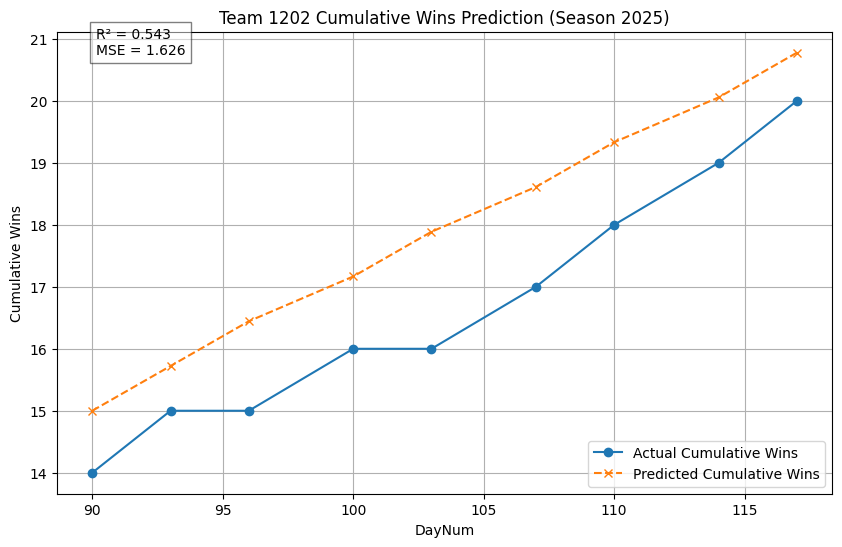

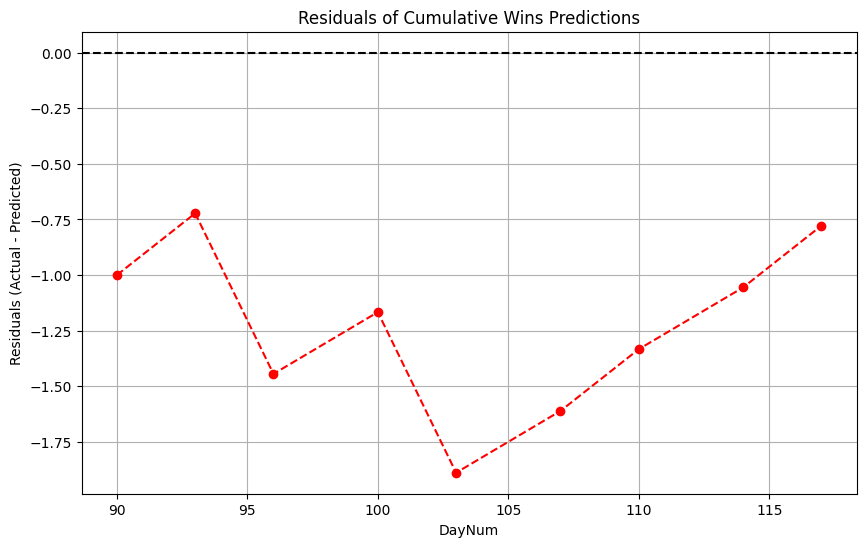

In [192]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')
# 예시로 데이터 개수를 제한하거나, 필요한 시즌만 필터링 가능
# regular_m = regular_m[regular_m['Season'] == 2025]

# 각 경기에 대해 두 개의 레코드를 생성: 승리 팀과 패배 팀
win_data = regular_m[['Season', 'DayNum', 'WTeamID']].copy()
win_data = win_data.rename(columns={'WTeamID': 'TeamID'})
win_data['Game_Result'] = 1

loss_data = regular_m[['Season', 'DayNum', 'LTeamID']].copy()
loss_data = loss_data.rename(columns={'LTeamID': 'TeamID'})
loss_data['Game_Result'] = 0

# 두 데이터를 합쳐 팀별 승패 시퀀스 데이터 생성
team_game_results = pd.concat([win_data, loss_data], ignore_index=True)
team_game_results = team_game_results.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 2. 팀별, 시즌별 누적 승수 계산 (실제 값 계산용)
team_game_results['Cumulative_Wins'] = team_game_results.groupby(['TeamID', 'Season'])['Game_Result'].cumsum()

# 3. 예시: 특정 팀과 특정 시즌의 데이터를 사용 (예: TeamID 1181, Season 2025)
example_team = team_game_results[(team_game_results['TeamID'] == 1202) & (team_game_results['Season'] == 2025)]
example_team = example_team.sort_values('DayNum')

print("예시 팀 데이터 (TeamID 1181, Season 2025):")
print(example_team[['DayNum', 'Game_Result', 'Cumulative_Wins']].head(10))

# 실제 개별 경기 결과 시퀀스 (0 또는 1)
X_sequence = example_team['Game_Result'].values.reshape(-1, 1)
# 실제 누적 승수 (ground truth): 각 경기마다 누적된 승수
actual_cum_wins = np.cumsum(X_sequence)

# 4. 데이터를 훈련셋과 테스트셋으로 분할 (예: 70% 훈련, 30% 테스트)
split_idx = int(0.7 * len(X_sequence))
X_train = X_sequence[:split_idx]
X_test = X_sequence[split_idx:]
actual_cum_wins_train = np.cumsum(X_train)
actual_cum_wins_test = np.cumsum(X_test)
# 테스트셋의 누적 승수는 훈련셋의 마지막 누적 승수와 이어지도록 조정
initial_cum_win = actual_cum_wins_train[-1]
actual_cum_wins_test_adjusted = initial_cum_win + actual_cum_wins_test

# 5. HMM 모델 정의 및 학습 (MultinomialHMM 사용)
model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
model.fit(X_train)

# 6. 훈련 데이터에 대해 숨겨진 상태 예측 및 상태-결과 매핑 생성
train_states = model.predict(X_train)
state_to_outcome = {}
unique_states = np.unique(train_states)
for state in unique_states:
    # 해당 상태의 평균 Game_Result 계산 (예: 만약 상태 내 값이 모두 1이면 평균은 1, 0이면 0)
    mean_val = X_train[train_states == state].mean()
    state_to_outcome[state] = mean_val  # 여기서 1 또는 0의 값이 나올 수 있음
print("훈련 데이터 상태 매핑:", state_to_outcome)

# 7. 테스트 데이터에 대해 HMM 모델 예측 및 상태 매핑 적용
test_states = model.predict(X_test)
predicted_game_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)

# 8. 예측된 개별 경기 결과를 누적하여 예측 누적 승수 계산
predicted_cum_wins_test = initial_cum_win + np.cumsum(predicted_game_results)

# 9. 평가: 누적 승수에 대한 R² 결정계수와 MSE 계산
r2_val = r2_score(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
mse_val = mean_squared_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
print("Test Set R²:", r2_val)
print("Mean Squared Error:", mse_val)

# 테스트 데이터의 실제 누적 승수와 예측 누적 승수를 비교하는 DataFrame 생성
comparison_df = pd.DataFrame({
    'DayNum': example_team.iloc[split_idx:]['DayNum'].values,
    'Actual_Cum_Wins': actual_cum_wins_test_adjusted.flatten(),
    'Predicted_Cum_Wins': predicted_cum_wins_test.flatten()
})
print("테스트 데이터 예시 비교:")
print(comparison_df.head())

# 10. 로그 우도, AIC, BIC 계산
logL = model.score(X_test)
print("Log Likelihood on Test Set:", logL)

# MultinomialHMM의 자유 파라미터 계산
# n_components: 상태 수, n_features: 관측 범주 (여기서는 0,1 → 2)
n_components = model.n_components
n_features = 2
k = (n_components - 1) + n_components*(n_components - 1) + n_components*(n_features - 1)
n_samples = X_test.shape[0]
AIC = 2 * k - 2 * logL
BIC = np.log(n_samples) * k - 2 * logL
  
print("자유 파라미터 수 (k):", k)
print("AIC:", AIC)
print("BIC:", BIC)

# --- 시각화 ---

# 1. 누적 승수 비교 그래프
plt.figure(figsize=(10,6))
plt.plot(comparison_df['DayNum'], comparison_df['Actual_Cum_Wins'], marker='o', linestyle='-', label='Actual Cumulative Wins')
plt.plot(comparison_df['DayNum'], comparison_df['Predicted_Cum_Wins'], marker='x', linestyle='--', label='Predicted Cumulative Wins')
plt.xlabel('DayNum')
plt.ylabel('Cumulative Wins')
plt.title(f'Team {1202} Cumulative Wins Prediction (Season 2025)')
plt.legend()
plt.grid(True)
plt.text(0.05, 0.95, f"R² = {r2_val:.3f}\nMSE = {mse_val:.3f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# 2. 잔차(Residuals) 플롯
residuals = comparison_df['Actual_Cum_Wins'] - comparison_df['Predicted_Cum_Wins']
plt.figure(figsize=(10,6))
plt.plot(comparison_df['DayNum'], residuals, marker='o', linestyle='--', color='red')
plt.xlabel('DayNum')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals of Cumulative Wins Predictions')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()


In [159]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 이미 계산한 actual_cum_wins_test_adjusted와 predicted_cum_wins_test가 있다고 가정합니다.
mse_val = mean_squared_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
mae_val = mean_absolute_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)

print("Mean Squared Error (MSE):", mse_val)
print("Mean Absolute Error (MAE):", mae_val)


Mean Squared Error (MSE): 0.12888888888888891
Mean Absolute Error (MAE): 0.28888888888888864


In [169]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')

# 각 경기마다 두 개의 레코드를 생성: 승리 팀과 패배 팀
win_data = regular_m[['Season', 'DayNum', 'WTeamID']].copy()
win_data = win_data.rename(columns={'WTeamID': 'TeamID'})
win_data['Game_Result'] = 1

loss_data = regular_m[['Season', 'DayNum', 'LTeamID']].copy()
loss_data = loss_data.rename(columns={'LTeamID': 'TeamID'})
loss_data['Game_Result'] = 0

# 두 데이터를 합쳐 팀별 승패 시퀀스 생성 및 정렬
team_game_results = pd.concat([win_data, loss_data], ignore_index=True)
team_game_results = team_game_results.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 팀별, 시즌별 누적 승수 계산 (실제 값 계산용)
team_game_results['Cumulative_Wins'] = team_game_results.groupby(['TeamID', 'Season'])['Game_Result'].cumsum()

# 2. 관심 있는 팀과 시즌 설정
team_id = 1181
seasons_list = [2015, 2016, 2017, 2018, 2019, 2022, 2023, 2024, 2025,1]

# 결과 저장 리스트
metrics_list = []

# 3. 각 시즌에 대해 HMM 모델 학습 및 평가
for season in seasons_list:
    season_data = team_game_results[(team_game_results['TeamID'] == team_id) & (team_game_results['Season'] == season)]
    season_data = season_data.sort_values('DayNum')
    
    # 데이터가 충분한 경우에만 진행 (예: 최소 5경기)
    if len(season_data) < 5:
        print(f"Season {season}: 데이터 부족 ({len(season_data)} 경기가 있음). Skipping.")
        continue
    
    # 개별 경기 결과 시퀀스 (0 또는 1) 및 누적 승수 계산
    X_sequence = season_data['Game_Result'].values.reshape(-1, 1)
    actual_cum_wins = np.cumsum(X_sequence)
    
    # 훈련/테스트 분할 (70% / 30%)
    split_idx = int(0.7 * len(X_sequence))
    X_train = X_sequence[:split_idx]
    X_test = X_sequence[split_idx:]
    actual_cum_wins_train = np.cumsum(X_train)
    actual_cum_wins_test = np.cumsum(X_test)
    # 테스트 누적 승수: 훈련 마지막 값과 이어지도록 조정
    initial_cum_win = actual_cum_wins_train[-1]
    actual_cum_wins_test_adjusted = initial_cum_win + actual_cum_wins_test
    
    # HMM 모델 학습 (MultinomialHMM 사용)
    model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
    model.fit(X_train)
    
    # 훈련 데이터 상태 매핑: 각 상태의 평균 Game_Result 계산
    train_states = model.predict(X_train)
    state_to_outcome = {}
    for state in np.unique(train_states):
        mean_val = X_train[train_states == state].mean()
        state_to_outcome[state] = mean_val
    # 테스트 데이터 예측 및 매핑 적용
    test_states = model.predict(X_test)
    predicted_game_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)
    
    # 예측된 개별 경기 결과 누적 승수 계산
    predicted_cum_wins_test = initial_cum_win + np.cumsum(predicted_game_results)
    
    # 평가: R², MSE, MAE 계산
    r2_val = r2_score(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
    mse_val = mean_squared_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
    mae_val = mean_absolute_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test)
    
    # 로그 우도 계산
    logL = model.score(X_test)
    # 자유 파라미터 계산 (MultinomialHMM: n_components=2, n_features=2 (observed categories: 0,1))
    n_components = model.n_components
    n_features = 2
    k_val = (n_components - 1) + n_components*(n_components - 1) + n_components*(n_features - 1)
    n_samples = X_test.shape[0]
    AIC = 2 * k_val - 2 * logL
    BIC = np.log(n_samples) * k_val - 2 * logL
    
    metrics_list.append({
        'Season': season,
        'R2': r2_val,
        'MSE': mse_val,
        'MAE': mae_val,
        'LogL': logL,
        'AIC': AIC,
        'BIC': BIC,
        'Games': len(X_sequence)
    })

# 결과 DataFrame 생성
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# 4. 시각화: 시즌별 평가 지표 플롯

# plt.figure(figsize=(10,6))
# plt.plot(metrics_df['Season'].astype(str), metrics_df['R2'], marker='o', linestyle='-', label='R2')
# plt.xlabel('Season')
# plt.ylabel('R2')
# plt.title(f'Team {team_id} R2 across Seasons')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(metrics_df['Season'].astype(str), metrics_df['MSE'], marker='o', linestyle='-', label='MSE')
# plt.plot(metrics_df['Season'].astype(str), metrics_df['MAE'], marker='x', linestyle='--', label='MAE')
# plt.xlabel('Season')
# plt.ylabel('Error')
# plt.title(f'Team {team_id} MSE and MAE across Seasons')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(metrics_df['Season'].astype(str), metrics_df['AIC'], marker='o', linestyle='-', label='AIC')
# plt.plot(metrics_df['Season'].astype(str), metrics_df['BIC'], marker='x', linestyle='--', label='BIC')
# plt.xlabel('Season')
# plt.ylabel('Information Criterion')
# plt.title(f'Team {team_id} AIC and BIC across Seasons')
# plt.legend()
# plt.grid(True)
# plt.show()



MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

Season 1: 데이터 부족 (0 경기가 있음). Skipping.
   Season        R2       MSE       MAE          LogL   AIC        BIC  Games
0    2015  0.948319  0.384504  0.513636  2.775558e-17  10.0  11.512925     33
1    2016  0.791231  0.519835  0.554545  2.775558e-17  10.0  11.512925     33
2    2017  0.761367  0.990033  0.849802  3.469447e-16  10.0  11.989476     35
3    2018  0.891185  0.587603  0.681818  2.775558e-17  10.0  11.512925     33
4    2019  0.430403  2.570248  1.380165  1.526557e-16  10.0  11.989476     34
5    2022  0.951422  0.338843  0.487603  1.526557e-16  10.0  11.989476     34
6    2023  0.904505  0.876033  0.793388  1.526557e-16  10.0  11.989476     34
7    2024  0.948017  0.220408  0.371429 -9.159340e-16  10.0  11.512925     32
8    2025  0.946303  0.315556  0.488889 -8.326673e-17  10.0  10.986123     30


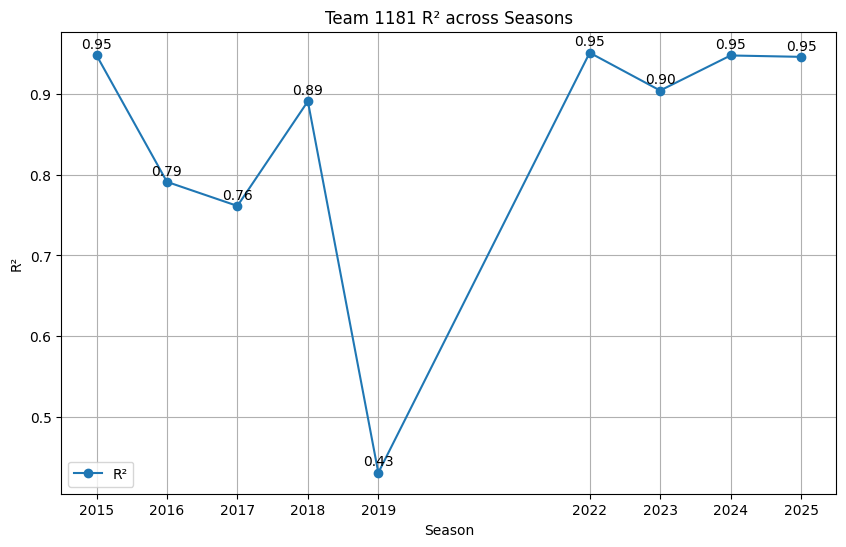

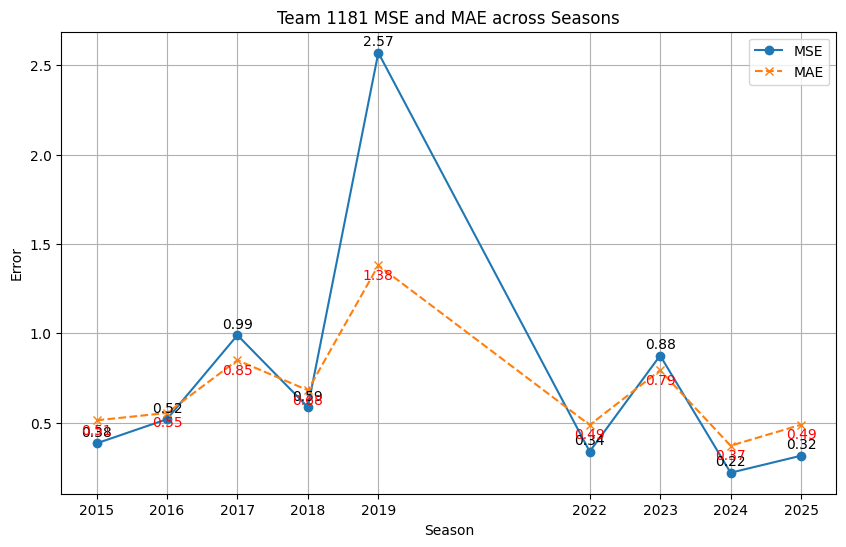

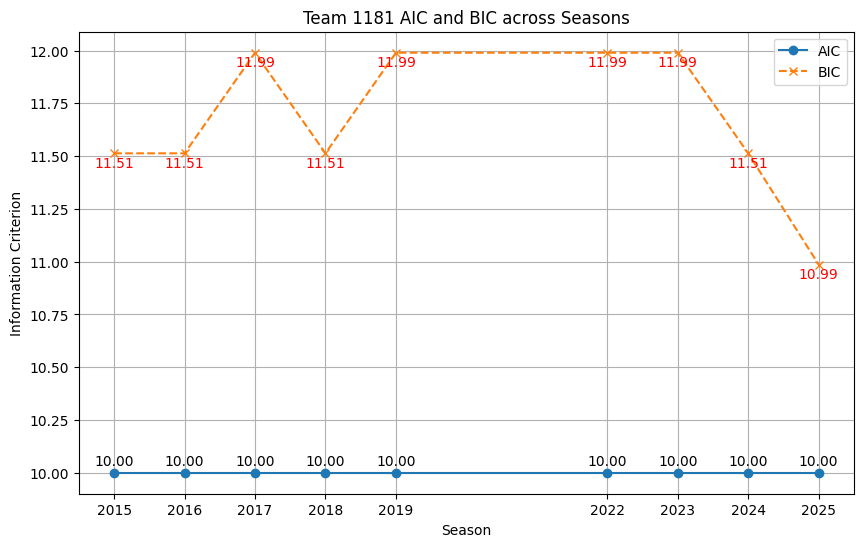

In [161]:
import matplotlib.pyplot as plt

# R² 그래프
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['R2'], marker='o', linestyle='-', label='R²')

# 데이터 포인트 위에 수치 표시 (각 시즌의 정확한 위치에 배치)
for idx, row in metrics_df.iterrows():
    plt.annotate(f"{row['R2']:.2f}", 
                 (row['Season'], row['R2']), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

plt.xlabel('Season')
plt.ylabel('R²')
plt.title(f'Team {team_id} R² across Seasons')
plt.xticks(metrics_df['Season'])  # x축 년도 표시
plt.legend()
plt.grid(True)
plt.show()

# MSE & MAE 그래프
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['MSE'], marker='o', linestyle='-', label='MSE')
plt.plot(metrics_df['Season'], metrics_df['MAE'], marker='x', linestyle='--', label='MAE')

# 데이터 포인트 위에 수치 표시
for idx, row in metrics_df.iterrows():
    plt.annotate(f"{row['MSE']:.2f}", 
                 (row['Season'], row['MSE']), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')
    plt.annotate(f"{row['MAE']:.2f}", 
                 (row['Season'], row['MAE']), 
                 textcoords="offset points", xytext=(0,-10), ha='center', fontsize=10, color='red')

plt.xlabel('Season')
plt.ylabel('Error')
plt.title(f'Team {team_id} MSE and MAE across Seasons')
plt.xticks(metrics_df['Season'])
plt.legend()
plt.grid(True)
plt.show()

# AIC & BIC 그래프
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['AIC'], marker='o', linestyle='-', label='AIC')
plt.plot(metrics_df['Season'], metrics_df['BIC'], marker='x', linestyle='--', label='BIC')

# 데이터 포인트 위에 수치 표시
for idx, row in metrics_df.iterrows():
    plt.annotate(f"{row['AIC']:.2f}", 
                 (row['Season'], row['AIC']), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')
    plt.annotate(f"{row['BIC']:.2f}", 
                 (row['Season'], row['BIC']), 
                 textcoords="offset points", xytext=(0,-10), ha='center', fontsize=10, color='red')

plt.xlabel('Season')
plt.ylabel('Information Criterion')
plt.title(f'Team {team_id} AIC and BIC across Seasons')
plt.xticks(metrics_df['Season'])
plt.legend()
plt.grid(True)
plt.show()


In [162]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')
# 필요에 따라 시즌 필터링 가능 (예: regular_m = regular_m[regular_m['Season'] == 2025])

# 각 경기에 대해 승리 팀과 패배 팀의 레코드를 생성
win_data = regular_m[['Season', 'DayNum', 'WTeamID']].copy()
win_data = win_data.rename(columns={'WTeamID': 'TeamID'})
win_data['Game_Result'] = 1

loss_data = regular_m[['Season', 'DayNum', 'LTeamID']].copy()
loss_data = loss_data.rename(columns={'LTeamID': 'TeamID'})
loss_data['Game_Result'] = 0

# 두 데이터를 합쳐 팀별 승패 시퀀스 생성
team_game_results = pd.concat([win_data, loss_data], ignore_index=True)
team_game_results = team_game_results.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 팀별, 시즌별 누적 승수 계산 (실제 값 계산용)
team_game_results['Cumulative_Wins'] = team_game_results.groupby(['TeamID', 'Season'])['Game_Result'].cumsum()

# 2. 예시: 특정 팀과 시즌의 데이터 사용 (예: TeamID 1181, Season 2018)
# (시즌이나 팀ID는 실제 데이터에 맞게 조정하세요.)
example_team = team_game_results[(team_game_results['TeamID'] == 1181) & (team_game_results['Season'] == 2025)]
example_team = example_team.sort_values('DayNum')
print("예시 팀 데이터:")
print(example_team[['DayNum', 'Game_Result', 'Cumulative_Wins']].head(10))

# 실제 경기 결과 시퀀스 (0 또는 1)
X_sequence = example_team['Game_Result'].values.reshape(-1, 1)

# 3. 교차검증: TimeSeriesSplit 사용 (시간 순서를 고려한 분할)
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []
mse_scores = []

fold = 1
for train_index, test_index in tscv.split(X_sequence):
    print(f"\nFold {fold}")
    # 훈련/테스트 데이터 분할
    X_train_fold, X_test_fold = X_sequence[train_index], X_sequence[test_index]
    
    # 훈련 데이터의 누적 승수 계산 (테스트 데이터의 누적 승수는 훈련 데이터 마지막 값에서 이어짐)
    actual_cum_train = np.cumsum(X_train_fold)
    initial_cum_win = actual_cum_train[-1] if len(actual_cum_train) > 0 else 0
    actual_cum_test_fold = initial_cum_win + np.cumsum(X_test_fold)
    
    # 4. HMM 모델 학습 (MultinomialHMM 사용)
    model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
    model.fit(X_train_fold)
    
    # 5. 훈련 데이터에 대해 숨겨진 상태 예측 및 상태-결과 매핑 생성
    train_states = model.predict(X_train_fold)
    state_to_outcome = {}
    unique_states = np.unique(train_states)
    for state in unique_states:
        # 해당 상태 내 평균 Game_Result 계산 (0 또는 1에 가까운 값)
        mean_val = X_train_fold[train_states == state].mean()
        state_to_outcome[state] = mean_val
    print("훈련 데이터 상태 매핑:", state_to_outcome)
    
    # 6. 테스트 데이터에 대해 HMM 상태 예측 및 상태 매핑 적용
    test_states = model.predict(X_test_fold)
    predicted_game_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)
    
    # 7. 예측된 개별 경기 결과를 누적하여 예측 누적 승수 계산
    predicted_cum_wins_test = initial_cum_win + np.cumsum(predicted_game_results)
    
    # 8. 평가: 누적 승수에 대한 R²와 MSE 계산
    r2 = r2_score(actual_cum_test_fold, predicted_cum_wins_test)
    mse = mean_squared_error(actual_cum_test_fold, predicted_cum_wins_test)
    print("Fold R²:", r2)
    print("Fold MSE:", mse)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    fold += 1

# 9. 전체 교차검증에 대한 평균 성능 지표 출력
print("\n교차검증 평균 R²:", np.mean(r2_scores))
print("교차검증 평균 MSE:", np.mean(mse_scores))


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

예시 팀 데이터:
       DayNum  Game_Result  Cumulative_Wins
82603       0            1                1
82604       4            1                2
82605       8            0                2
82606      12            1                3
82607      18            1                4
82608      22            0                4
82609      25            1                5
82610      30            1                6
82611      34            1                7
82612      36            1                8

Fold 1
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.75), np.int64(1): np.float64(1.0)}
Fold R²: 0.8125
Fold MSE: 0.375

Fold 2
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.7777777777777778), np.int64(1): np.float64(1.0)}
Fold R²: 0.8518518518518516
Fold MSE: 0.2962962962962967

Fold 3
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.8571428571428571), np.int64(1): np.float64(1.0)}
Fold R²: 0.938775510204082
Fold MSE: 0.12244897959183587

Fold 4
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.8947368421052632), np.int64(1):

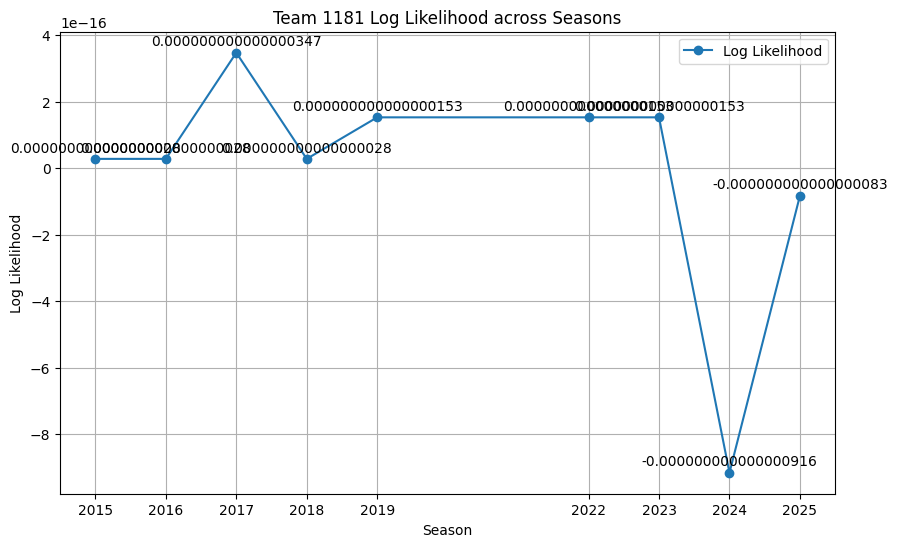

In [163]:
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['LogL'], marker='o', linestyle='-', label='Log Likelihood')

# 소수점 자릿수를 늘려 수치 표시
for idx, row in metrics_df.iterrows():
    plt.annotate(f"{row['LogL']:.18f}",  # 10자리까지 표시
                 (row['Season'], row['LogL']), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

plt.xlabel('Season')
plt.ylabel('Log Likelihood')
plt.title(f'Team {team_id} Log Likelihood across Seasons')
plt.xticks(metrics_df['Season'])
plt.legend()
plt.grid(True)
plt.show()


In [164]:
print(metrics_df['LogL'].describe())


count    9.000000e+00
mean    -1.233581e-17
std      3.600507e-16
min     -9.159340e-16
25%      2.775558e-17
50%      2.775558e-17
75%      1.526557e-16
max      3.469447e-16
Name: LogL, dtype: float64


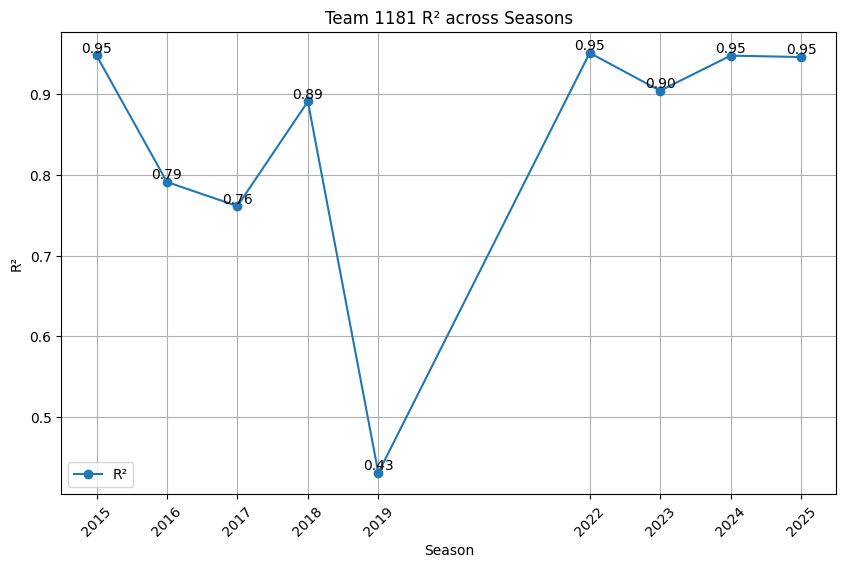

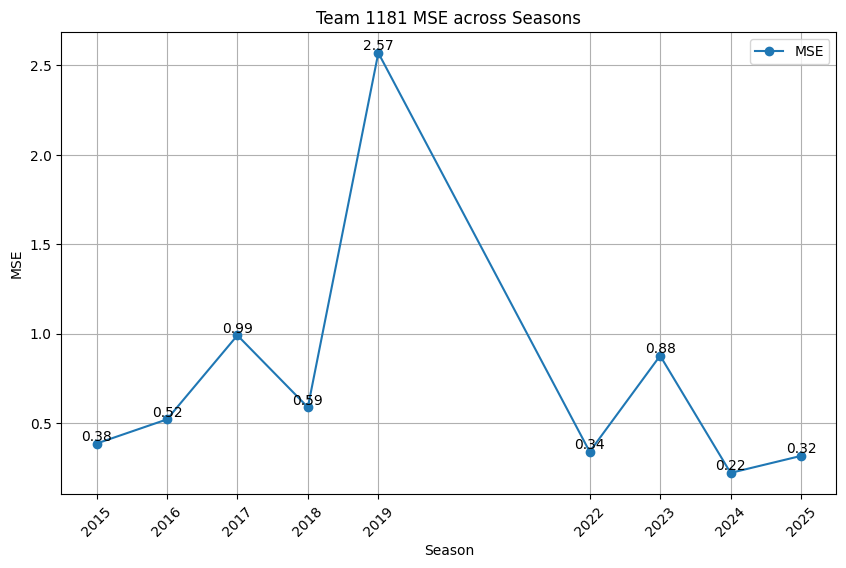

In [165]:
import matplotlib.pyplot as plt

# R² 값 시각화
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['R2'], marker='o', linestyle='-', label='R²')
for idx, row in metrics_df.iterrows():
    plt.text(row['Season'], row['R2'], f"{row['R2']:.2f}", fontsize=10, ha='center', va='bottom')
plt.xlabel('Season')
plt.ylabel('R²')
plt.title(f"Team {team_id} R² across Seasons")
plt.xticks(metrics_df['Season'], rotation=45)  # X축 눈금 회전
plt.legend()
plt.grid(True)
plt.show()

# MSE 값 시각화
plt.figure(figsize=(10,6))
plt.plot(metrics_df['Season'], metrics_df['MSE'], marker='o', linestyle='-', label='MSE')
for idx, row in metrics_df.iterrows():
    plt.text(row['Season'], row['MSE'], f"{row['MSE']:.2f}", fontsize=10, ha='center', va='bottom')
plt.xlabel('Season')
plt.ylabel('MSE')
plt.title(f"Team {team_id} MSE across Seasons")
plt.xticks(metrics_df['Season'], rotation=45)  # X축 눈금 회전
plt.legend()
plt.grid(True)
plt.show()


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

예시 팀 데이터:
       DayNum  Game_Result  Cumulative_Wins
82603       0            1                1
82604       4            1                2
82605       8            0                2
82606      12            1                3
82607      18            1                4
82608      22            0                4
82609      25            1                5
82610      30            1                6
82611      34            1                7
82612      36            1                8

Fold 1
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.75), np.int64(1): np.float64(1.0)}
Fold R²: 0.8125
Fold MSE: 0.375

Fold 2
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.7777777777777778), np.int64(1): np.float64(1.0)}
Fold R²: 0.8518518518518516
Fold MSE: 0.2962962962962967

Fold 3
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.8571428571428571), np.int64(1): np.float64(1.0)}
Fold R²: 0.938775510204082
Fold MSE: 0.12244897959183587

Fold 4
훈련 데이터 상태 매핑: {np.int64(0): np.float64(0.8947368421052632), np.int64(1):

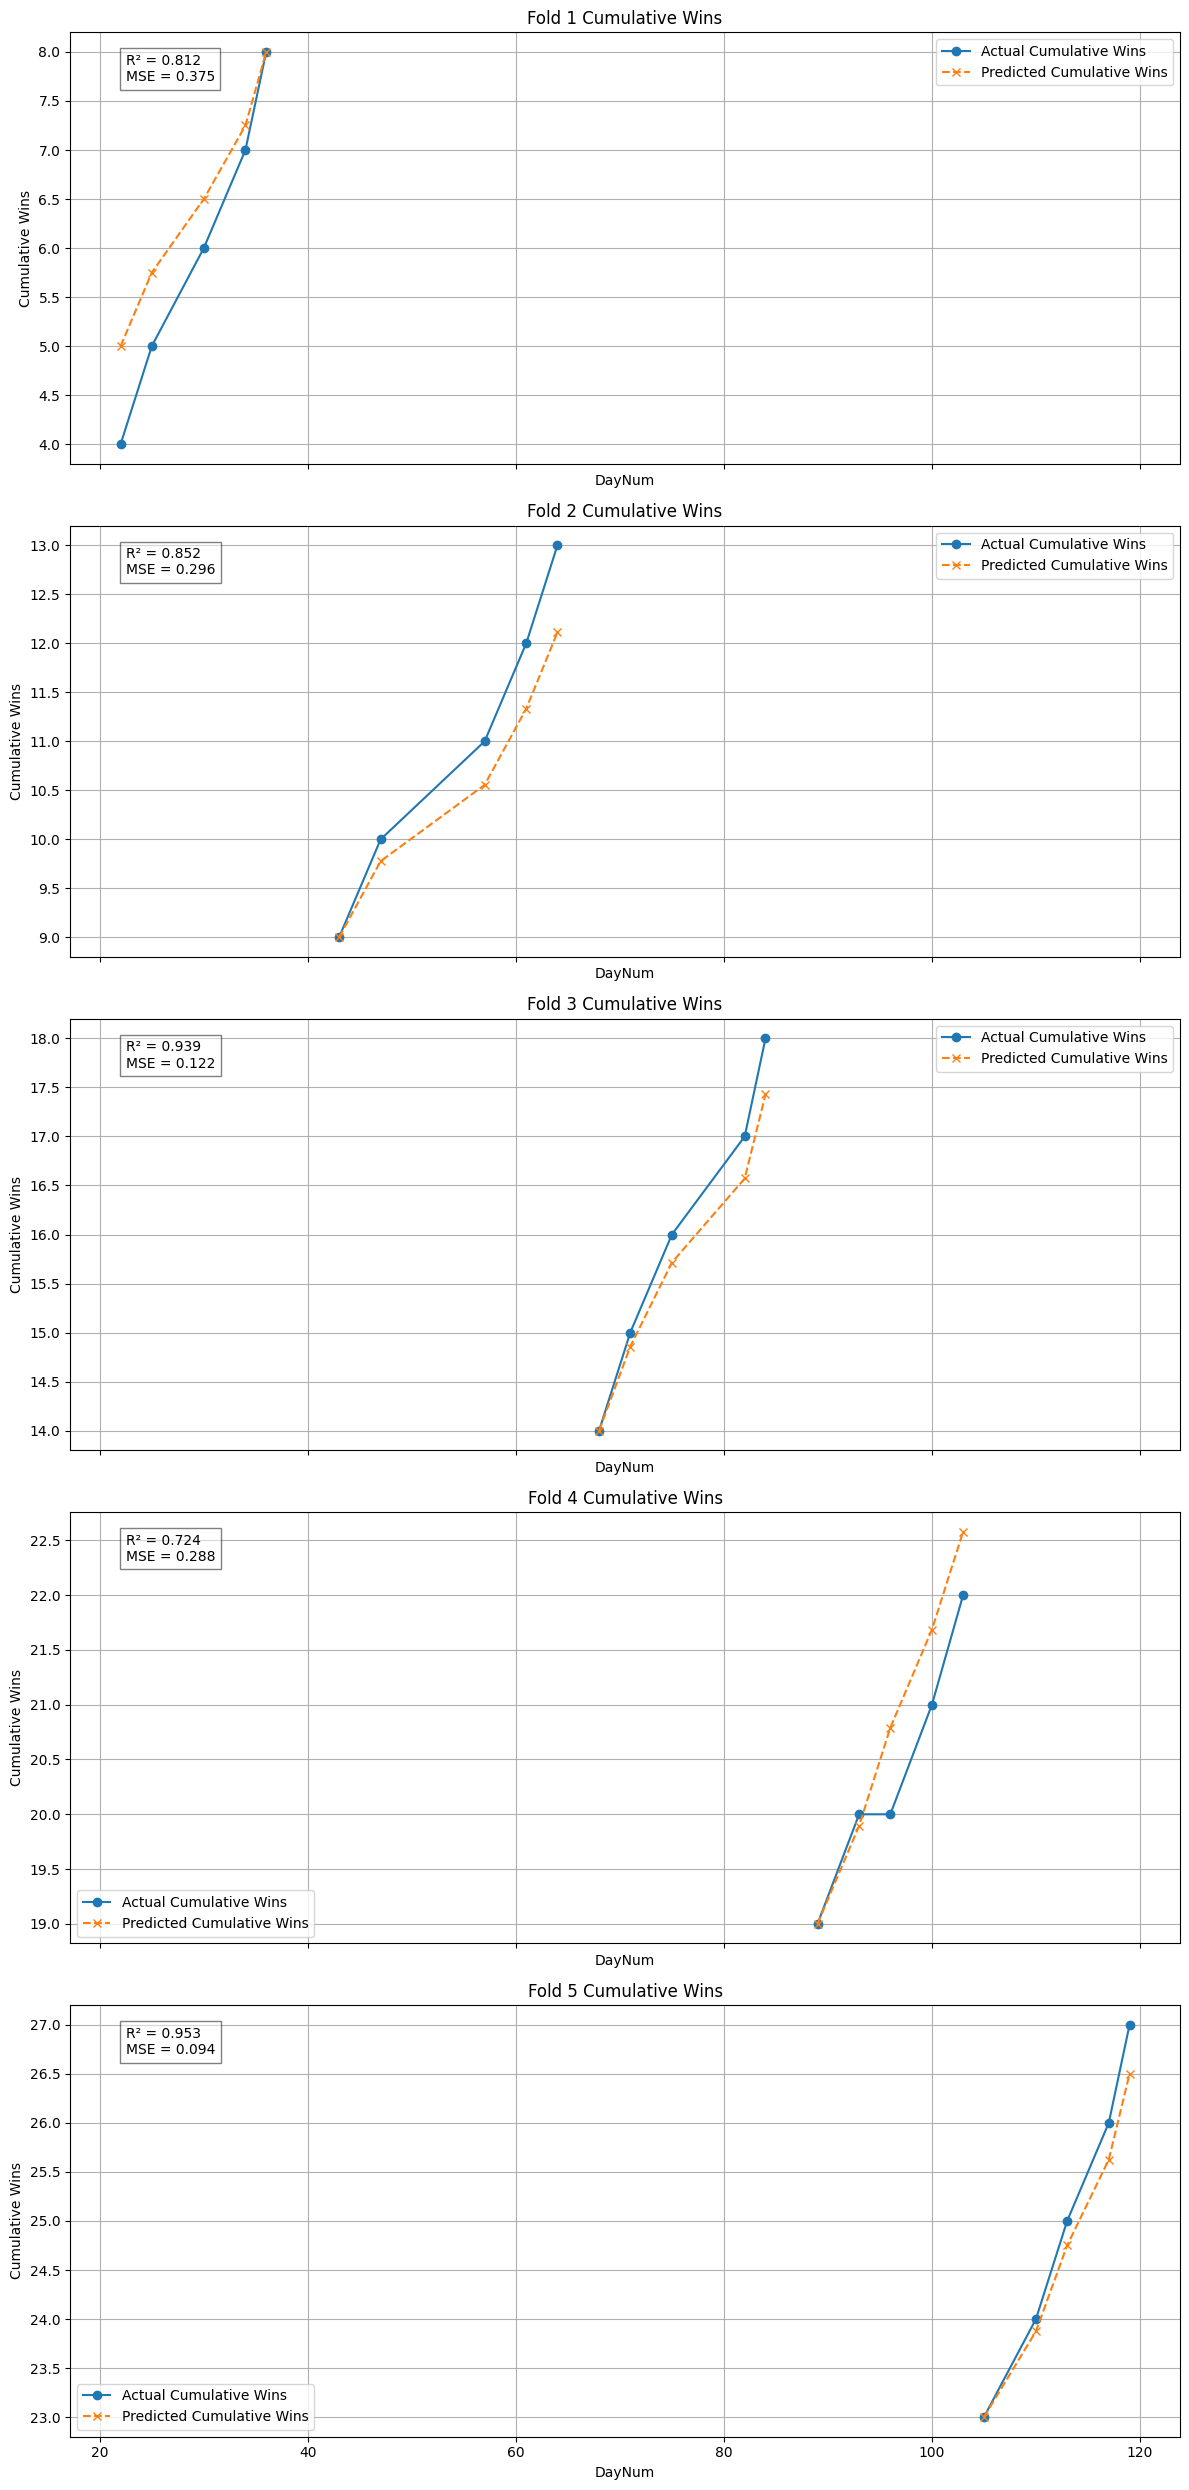

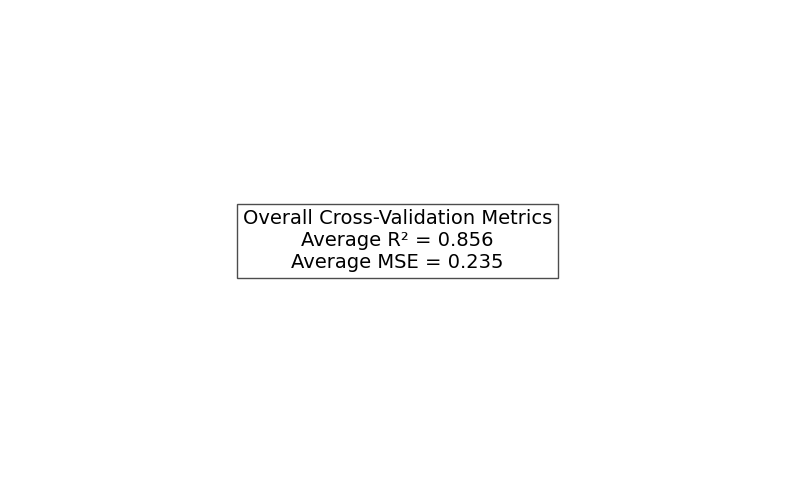

In [166]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 데이터 로드 및 전처리
regular_m = pd.read_csv(r"../TP8_ML/data/MRegularSeasonCompactResults.csv", encoding='utf-8')
# 필요에 따라 시즌 필터링 가능 (예: regular_m = regular_m[regular_m['Season'] == 2025])

# 각 경기에 대해 승리 팀과 패배 팀의 레코드를 생성
win_data = regular_m[['Season', 'DayNum', 'WTeamID']].copy()
win_data = win_data.rename(columns={'WTeamID': 'TeamID'})
win_data['Game_Result'] = 1

loss_data = regular_m[['Season', 'DayNum', 'LTeamID']].copy()
loss_data = loss_data.rename(columns={'LTeamID': 'TeamID'})
loss_data['Game_Result'] = 0

# 두 데이터를 합쳐 팀별 승패 시퀀스 생성
team_game_results = pd.concat([win_data, loss_data], ignore_index=True)
team_game_results = team_game_results.sort_values(by=['TeamID', 'Season', 'DayNum']).reset_index(drop=True)

# 팀별, 시즌별 누적 승수 계산 (실제 값 계산용)
team_game_results['Cumulative_Wins'] = team_game_results.groupby(['TeamID', 'Season'])['Game_Result'].cumsum()

# 2. 예시: 특정 팀과 시즌의 데이터 사용 (예: TeamID 1181, Season 2018)
# (시즌이나 팀ID는 실제 데이터에 맞게 조정하세요.)
example_team = team_game_results[(team_game_results['TeamID'] == 1181) & (team_game_results['Season'] == 2025)]
example_team = example_team.sort_values('DayNum')
print("예시 팀 데이터:")
print(example_team[['DayNum', 'Game_Result', 'Cumulative_Wins']].head(10))

# 실제 경기 결과 시퀀스 (0 또는 1)
X_sequence = example_team['Game_Result'].values.reshape(-1, 1)

# 3. 교차검증: TimeSeriesSplit 사용 (시간 순서를 고려한 분할)
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []
mse_scores = []
fold_results = []  # 시각화를 위한 결과 저장

fold = 1
for train_index, test_index in tscv.split(X_sequence):
    print(f"\nFold {fold}")
    # 훈련/테스트 데이터 분할
    X_train_fold, X_test_fold = X_sequence[train_index], X_sequence[test_index]
    
    # 훈련 데이터의 누적 승수 계산 (테스트 데이터의 누적 승수는 훈련 데이터 마지막 값에서 이어짐)
    actual_cum_train = np.cumsum(X_train_fold)
    initial_cum_win = actual_cum_train[-1] if len(actual_cum_train) > 0 else 0
    actual_cum_test_fold = initial_cum_win + np.cumsum(X_test_fold)
    
    # 4. HMM 모델 학습 (MultinomialHMM 사용)
    model = MultinomialHMM(n_components=2, n_iter=1000, random_state=42)
    model.fit(X_train_fold)
    
    # 5. 훈련 데이터에 대해 숨겨진 상태 예측 및 상태-결과 매핑 생성
    train_states = model.predict(X_train_fold)
    state_to_outcome = {}
    unique_states = np.unique(train_states)
    for state in unique_states:
        # 해당 상태 내 평균 Game_Result 계산 (0 또는 1에 가까운 값)
        mean_val = X_train_fold[train_states == state].mean()
        state_to_outcome[state] = mean_val
    print("훈련 데이터 상태 매핑:", state_to_outcome)
    
    # 6. 테스트 데이터에 대해 HMM 상태 예측 및 상태 매핑 적용
    test_states = model.predict(X_test_fold)
    predicted_game_results = np.array([state_to_outcome[s] for s in test_states]).reshape(-1, 1)
    
    # 7. 예측된 개별 경기 결과를 누적하여 예측 누적 승수 계산
    predicted_cum_wins_test = initial_cum_win + np.cumsum(predicted_game_results)
    
    # 8. 평가: 누적 승수에 대한 R²와 MSE 계산
    r2 = r2_score(actual_cum_test_fold, predicted_cum_wins_test)
    mse = mean_squared_error(actual_cum_test_fold, predicted_cum_wins_test)
    print("Fold R²:", r2)
    print("Fold MSE:", mse)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    
    # 테스트 데이터에 해당하는 DayNum 추출 (원본 데이터에서 인덱스 사용)
    test_daynum = example_team.iloc[test_index]['DayNum'].values
    fold_results.append({
        'fold': fold,
        'day_nums': test_daynum,
        'actual': actual_cum_test_fold.flatten(),
        'predicted': predicted_cum_wins_test.flatten(),
        'r2': r2,
        'mse': mse
    })
    
    fold += 1

# 전체 교차검증 평균 성능 지표 출력
avg_r2 = np.mean(r2_scores)
avg_mse = np.mean(mse_scores)
print("\n교차검증 평균 R²:", avg_r2)
print("교차검증 평균 MSE:", avg_mse)

# --- 시각화: 각 Fold별 누적 승수 비교 ---
n_splits = tscv.get_n_splits()
fig, axs = plt.subplots(n_splits, 1, figsize=(12, 5 * n_splits), sharex=True)
if n_splits == 1:
    axs = [axs]

for result in fold_results:
    ax = axs[result['fold'] - 1]
    ax.plot(result['day_nums'], result['actual'], marker='o', linestyle='-', label='Actual Cumulative Wins')
    ax.plot(result['day_nums'], result['predicted'], marker='x', linestyle='--', label='Predicted Cumulative Wins')
    ax.set_title(f'Fold {result["fold"]} Cumulative Wins')
    ax.set_xlabel('DayNum')
    ax.set_ylabel('Cumulative Wins')
    ax.legend()
    ax.grid(True)
    # 각 폴드별 R²와 MSE 값을 그래프 내부에 텍스트로 표시 (좌측 상단)
    ax.text(0.05, 0.95, f"R² = {result['r2']:.3f}\nMSE = {result['mse']:.3f}",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# --- 추가: 전체 평균 성능 지표를 하나의 플롯에 텍스트로 표시 (옵션) ---
plt.figure(figsize=(10,6))
plt.text(0.5, 0.5, f"Overall Cross-Validation Metrics\nAverage R² = {avg_r2:.3f}\nAverage MSE = {avg_mse:.3f}",
         fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.axis('off')
plt.show()


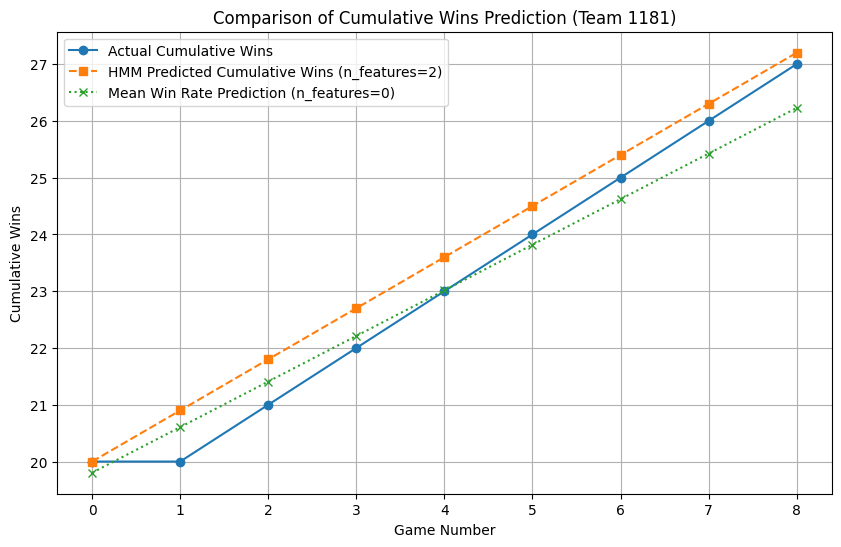

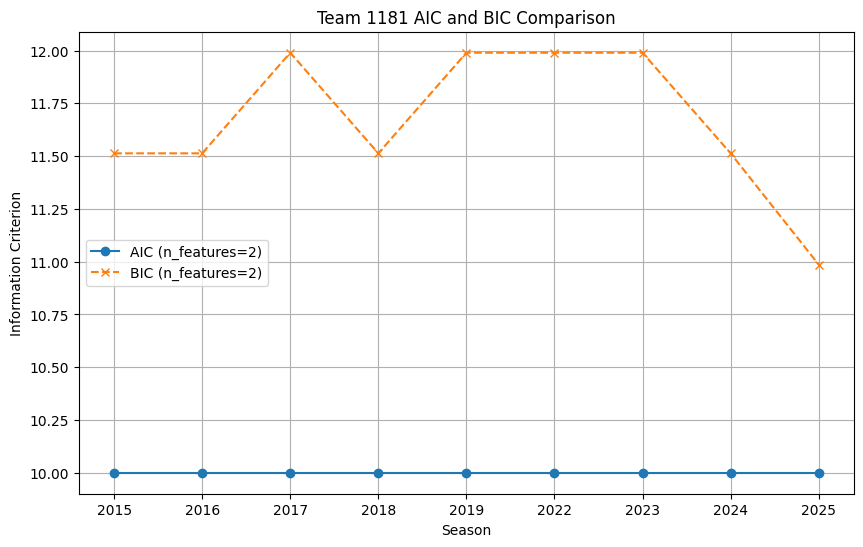

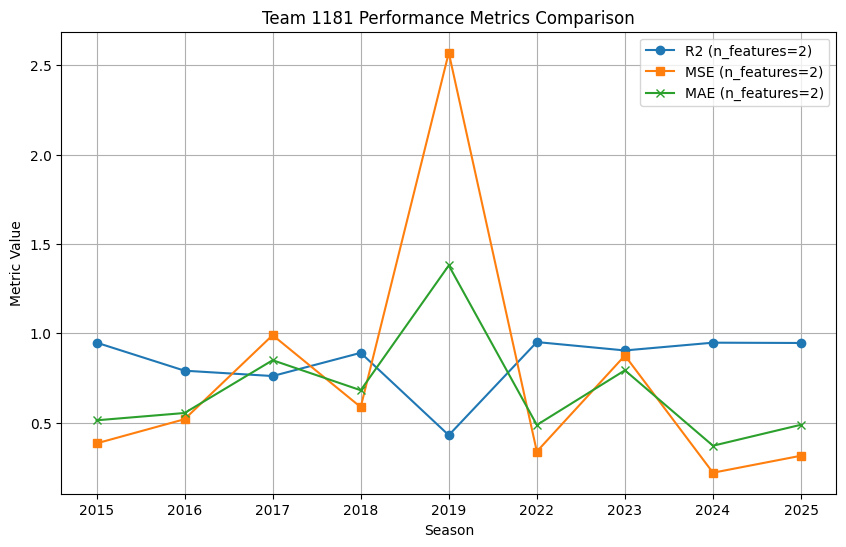

In [170]:
import matplotlib.pyplot as plt

# 단순 평균 승률을 기반으로 한 누적 승수 예측 (요인 0개 가정)
mean_win_rate = team_game_results[team_game_results['TeamID'] == team_id]['Game_Result'].mean()
predicted_cum_wins_mean = np.arange(1, len(X_test) + 1) * mean_win_rate + initial_cum_win

# 그래프 1: 누적 승수 비교
plt.figure(figsize=(10, 6))
plt.plot(actual_cum_wins_test_adjusted, label='Actual Cumulative Wins', marker='o')
plt.plot(predicted_cum_wins_test, label='HMM Predicted Cumulative Wins (n_features=2)', linestyle='--', marker='s')
plt.plot(predicted_cum_wins_mean, label='Mean Win Rate Prediction (n_features=0)', linestyle=':', marker='x')
plt.xlabel('Game Number')
plt.ylabel('Cumulative Wins')
plt.title(f'Comparison of Cumulative Wins Prediction (Team {team_id})')
plt.legend()
plt.grid(True)
plt.show()

# 그래프 2: AIC, BIC 비교 (단순 예측은 AIC/BIC 없음)
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Season'].astype(str), metrics_df['AIC'], marker='o', linestyle='-', label='AIC (n_features=2)')
plt.plot(metrics_df['Season'].astype(str), metrics_df['BIC'], marker='x', linestyle='--', label='BIC (n_features=2)')
plt.xlabel('Season')
plt.ylabel('Information Criterion')
plt.title(f'Team {team_id} AIC and BIC Comparison')
plt.legend()
plt.grid(True)
plt.show()

# 그래프 3: R², MSE, MAE 비교
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Season'].astype(str), metrics_df['R2'], marker='o', linestyle='-', label='R2 (n_features=2)')
plt.plot(metrics_df['Season'].astype(str), metrics_df['MSE'], marker='s', linestyle='-', label='MSE (n_features=2)')
plt.plot(metrics_df['Season'].astype(str), metrics_df['MAE'], marker='x', linestyle='-', label='MAE (n_features=2)')
plt.xlabel('Season')
plt.ylabel('Metric Value')
plt.title(f'Team {team_id} Performance Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

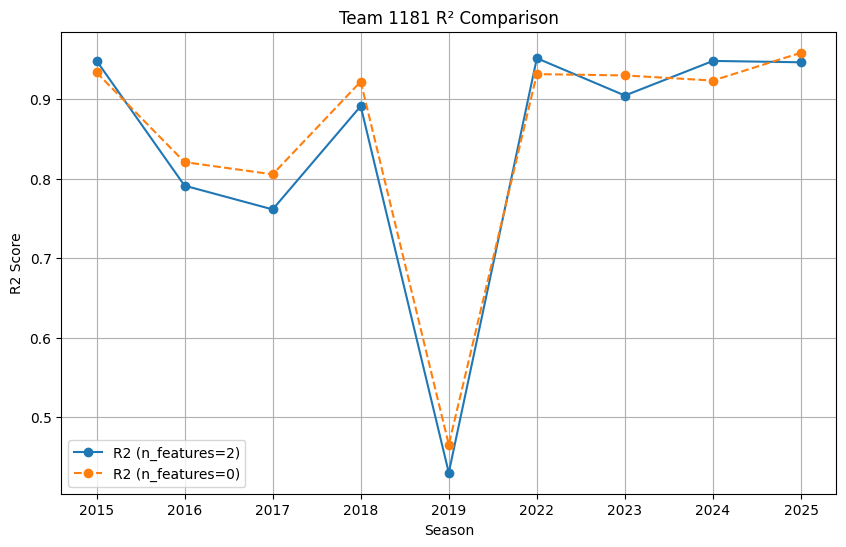

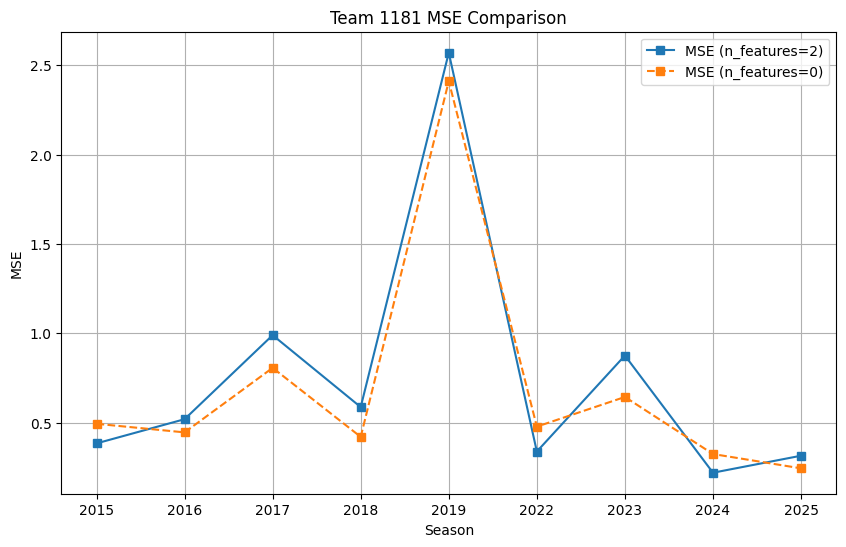

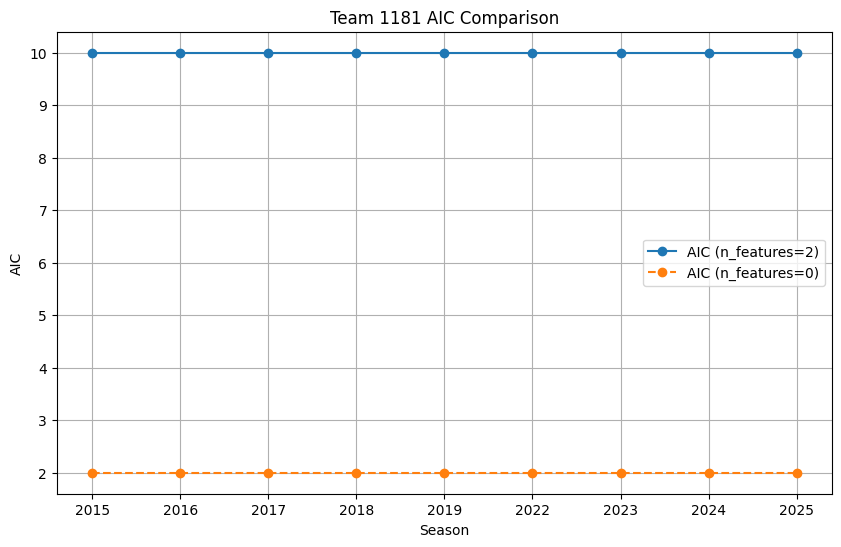

In [171]:
metrics_list_no_feature = []

for season in seasons_list:
    season_data = team_game_results[(team_game_results['TeamID'] == team_id) & (team_game_results['Season'] == season)]
    season_data = season_data.sort_values('DayNum')

    if len(season_data) < 5:
        continue

    X_sequence = season_data['Game_Result'].values.reshape(-1, 1)
    actual_cum_wins = np.cumsum(X_sequence)

    split_idx = int(0.7 * len(X_sequence))
    X_train = X_sequence[:split_idx]
    X_test = X_sequence[split_idx:]
    actual_cum_wins_train = np.cumsum(X_train)
    actual_cum_wins_test = np.cumsum(X_test)
    initial_cum_win = actual_cum_wins_train[-1]
    actual_cum_wins_test_adjusted = initial_cum_win + actual_cum_wins_test

    # HMM 모델 (n_components=1로 설정하여 의미 없는 모델 만들기)
    model_no_feature = MultinomialHMM(n_components=1, n_iter=1000, random_state=42)
    model_no_feature.fit(X_train)

    test_states_no_feature = model_no_feature.predict(X_test)
    predicted_game_results_no_feature = np.array([X_train.mean()] * len(X_test)).reshape(-1, 1)

    predicted_cum_wins_test_no_feature = initial_cum_win + np.cumsum(predicted_game_results_no_feature)

    r2_val_no_feature = r2_score(actual_cum_wins_test_adjusted, predicted_cum_wins_test_no_feature)
    mse_val_no_feature = mean_squared_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test_no_feature)
    mae_val_no_feature = mean_absolute_error(actual_cum_wins_test_adjusted, predicted_cum_wins_test_no_feature)

    logL_no_feature = model_no_feature.score(X_test)
    k_val_no_feature = 1  # 자유도 최소화
    n_samples = X_test.shape[0]
    AIC_no_feature = 2 * k_val_no_feature - 2 * logL_no_feature
    BIC_no_feature = np.log(n_samples) * k_val_no_feature - 2 * logL_no_feature

    metrics_list_no_feature.append({
        'Season': season,
        'R2': r2_val_no_feature,
        'MSE': mse_val_no_feature,
        'MAE': mae_val_no_feature,
        'LogL': logL_no_feature,
        'AIC': AIC_no_feature,
        'BIC': BIC_no_feature,
        'Games': len(X_sequence)
    })

metrics_df_no_feature = pd.DataFrame(metrics_list_no_feature)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Season'].astype(str), metrics_df['R2'], marker='o', linestyle='-', label='R2 (n_features=2)')
plt.plot(metrics_df_no_feature['Season'].astype(str), metrics_df_no_feature['R2'], marker='o', linestyle='--', label='R2 (n_features=0)')
plt.xlabel('Season')
plt.ylabel('R2 Score')
plt.title(f'Team {team_id} R² Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Season'].astype(str), metrics_df['MSE'], marker='s', linestyle='-', label='MSE (n_features=2)')
plt.plot(metrics_df_no_feature['Season'].astype(str), metrics_df_no_feature['MSE'], marker='s', linestyle='--', label='MSE (n_features=0)')
plt.xlabel('Season')
plt.ylabel('MSE')
plt.title(f'Team {team_id} MSE Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Season'].astype(str), metrics_df['AIC'], marker='o', linestyle='-', label='AIC (n_features=2)')
plt.plot(metrics_df_no_feature['Season'].astype(str), metrics_df_no_feature['AIC'], marker='o', linestyle='--', label='AIC (n_features=0)')
plt.xlabel('Season')
plt.ylabel('AIC')
plt.title(f'Team {team_id} AIC Comparison')
plt.legend()
plt.grid(True)
plt.show()


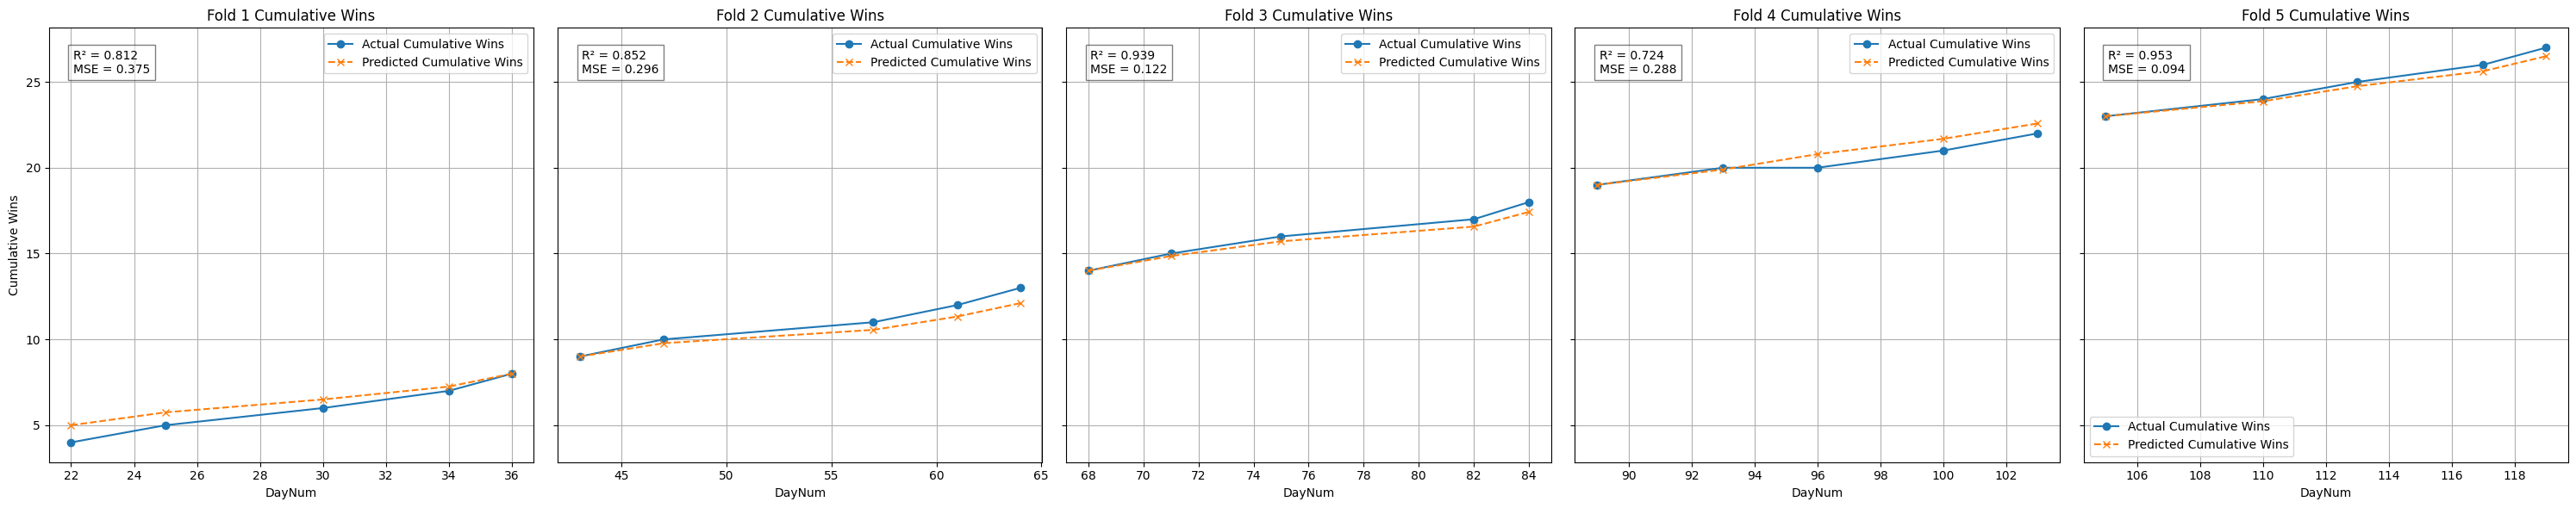

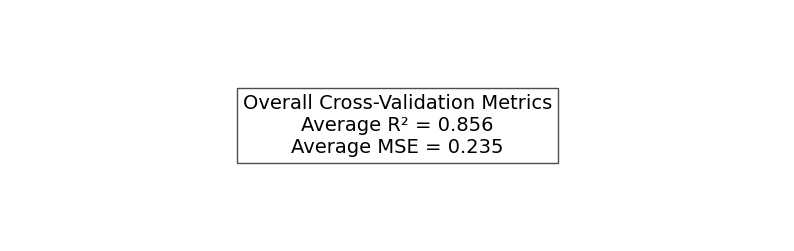

In [172]:
# --- 시각화: 가로로 길게 펼친 Fold별 누적 승수 비교 ---
n_splits = tscv.get_n_splits()
fig, axs = plt.subplots(1, n_splits, figsize=(6 * n_splits, 6), sharey=True)

if n_splits == 1:
    axs = [axs]

for result, ax in zip(fold_results, axs):
    ax.plot(result['day_nums'], result['actual'], marker='o', linestyle='-', label='Actual Cumulative Wins')
    ax.plot(result['day_nums'], result['predicted'], marker='x', linestyle='--', label='Predicted Cumulative Wins')
    ax.set_title(f'Fold {result["fold"]} Cumulative Wins')
    ax.set_xlabel('DayNum')
    ax.grid(True)
    ax.legend()
    ax.text(0.05, 0.95, f"R² = {result['r2']:.3f}\nMSE = {result['mse']:.3f}",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5))

axs[0].set_ylabel('Cumulative Wins')  # 첫 번째 그래프만 y축 라벨 표시

plt.tight_layout()
plt.show()

# --- 추가: 전체 평균 성능 지표를 하나의 플롯에 텍스트로 표시 ---
plt.figure(figsize=(10, 3))
plt.text(0.5, 0.5, f"Overall Cross-Validation Metrics\nAverage R² = {avg_r2:.3f}\nAverage MSE = {avg_mse:.3f}",
         fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.axis('off')
plt.show()
